In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [2]:
# データの読み込み
data = pd.read_csv('dataframe.csv')
X = data.iloc[:, :-1].values  # 入力データ (スピン配位)
y = data.iloc[:, -1].values   # 教師データ (温度)

In [3]:
# データのサイズを確認
X.shape , y.shape

((25000, 100), (25000,))

In [4]:
y

array([0.01, 0.01, 0.01, ..., 6.  , 6.  , 6.  ])

In [5]:
# データの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [6]:
# NumPy配列からPyTorchのテンソルに変換
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # (25000,) -> (25000, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)    # (6250,) -> (6250, 1)

In [7]:
y_train

tensor([[3.0000],
        [0.5000],
        [2.2500],
        ...,
        [0.0100],
        [3.7500],
        [5.7500]])

正解データはone-hot表現にする必要がある

In [8]:
import torch

# y_trainテンソルを新しいテンソルに変換する関数を定義
def to_one_hot(y_train, num_classes=25):
    # one-hotベクトルの初期化
    one_hot = torch.zeros(len(y_train), num_classes)
    
    # 各要素を25次元のone-hotベクトルに変換
    for i, val in enumerate(y_train):
        index = int((val - 0.01) / 0.24)  # 正しいインデックスの計算
        one_hot[i, index] = 1.0
    
    return one_hot

# y_train,y_testをone-hotベクトルに変換
one_hot_y_train = to_one_hot(y_train, num_classes=25)
one_hot_y_test = to_one_hot(y_test, num_classes=25)

In [9]:
one_hot_y_train

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

In [10]:
y_train[12]

tensor([5.5000])

In [11]:
one_hot_y_train[12]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0.])

In [12]:
# データセットの作成
train_dataset = TensorDataset(X_train, one_hot_y_train)
test_dataset = TensorDataset(X_test, one_hot_y_test)

In [13]:
train_dataset[0]

(tensor([ 1.,  1., -1.,  1.,  1., -1., -1., -1.,  1., -1.,  1.,  1.,  1.,  1.,
          1., -1., -1.,  1.,  1.,  1., -1.,  1.,  1.,  1., -1., -1.,  1., -1.,
         -1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1., -1., -1., -1., -1.,
         -1., -1., -1., -1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1., -1.,
         -1., -1.,  1., -1., -1., -1.,  1.,  1., -1., -1., -1., -1., -1., -1.,
         -1., -1.,  1., -1.,  1.,  1.,  1., -1.,  1.,  1., -1., -1.,  1.,  1.,
          1.,  1.,  1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.]))

In [26]:
# DataLoaderの設定（バッチサイズ1250）
train_loader = DataLoader(train_dataset, batch_size=6250, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=6250)

データの参照

In [27]:
x, t = next(iter(train_loader))
x.shape, t.shape

(torch.Size([6250, 100]), torch.Size([6250, 25]))

In [29]:
for x, t in train_loader:
    print(t)
    print(t.shape)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
torch.Size([6250, 25])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
torch.Size([6250, 25])


In [17]:
# ニューラルネットワークモデルの定義
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

In [18]:
# モデルの初期化
input_size = 100
hidden_size = 64
output_size = 25
model = NeuralNetwork(input_size, hidden_size, output_size)

In [19]:
print(model)

NeuralNetwork(
  (fc1): Linear(in_features=100, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=25, bias=True)
)


In [20]:
# KLダイバージェンス損失関数の定義
class KLDivergenceLoss(nn.Module):
    def __init__(self):
        super(KLDivergenceLoss, self).__init__()

    def forward(self, output, target):
        loss = nn.KLDivLoss(reduction='sum')(torch.log(output), target)
        return loss

In [21]:
# 損失関数と最適化アルゴリズムの設定
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [32]:
# 学習の実行
num_epochs = 7500
train_losses = []
train_accs = []
test_losses = []
test_accs = []
for epoch in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, targets)
        loss.backward()
        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)      # outputの一番値が大きい成分
        targets = torch.argmax(targets, dim=1)  # targetの一番値が大きい成分
        running_acc += torch.mean(pred.eq(targets).float()) # predとtargetが同じになった数の平均
        optimizer.step()
    running_loss /= len(train_loader)   # 12500個のデータ全体での損失関数の平均
    running_acc /= len(train_loader)    # 12500個のデータ全体での正解率
    train_losses.append(running_loss)
    train_accs.append(running_acc)
    
    print("epoch: {}, loss: {}, acc: {}".format(epoch, running_loss, running_acc))

epoch: 0, loss: 3.2163054943084717, acc: 0.046800002455711365
epoch: 1, loss: 3.2098257541656494, acc: 0.04423999786376953
epoch: 2, loss: 3.208539605140686, acc: 0.05040000006556511
epoch: 3, loss: 3.2060675621032715, acc: 0.058720000088214874
epoch: 4, loss: 3.203198194503784, acc: 0.07527999579906464
epoch: 5, loss: 3.1999908685684204, acc: 0.08551999926567078
epoch: 6, loss: 3.1961969137191772, acc: 0.09160000085830688
epoch: 7, loss: 3.192587375640869, acc: 0.09775999933481216
epoch: 8, loss: 3.187833309173584, acc: 0.10232000052928925
epoch: 9, loss: 3.1822136640548706, acc: 0.10799999535083771
epoch: 10, loss: 3.1767995357513428, acc: 0.11183999478816986
epoch: 11, loss: 3.171072483062744, acc: 0.11552000045776367
epoch: 12, loss: 3.165653347969055, acc: 0.11912000179290771
epoch: 13, loss: 3.1601818799972534, acc: 0.12624000012874603
epoch: 14, loss: 3.15461003780365, acc: 0.13624000549316406
epoch: 15, loss: 3.149454951286316, acc: 0.14168000221252441
epoch: 16, loss: 3.144010

損失関数と正解率のグラフの作成

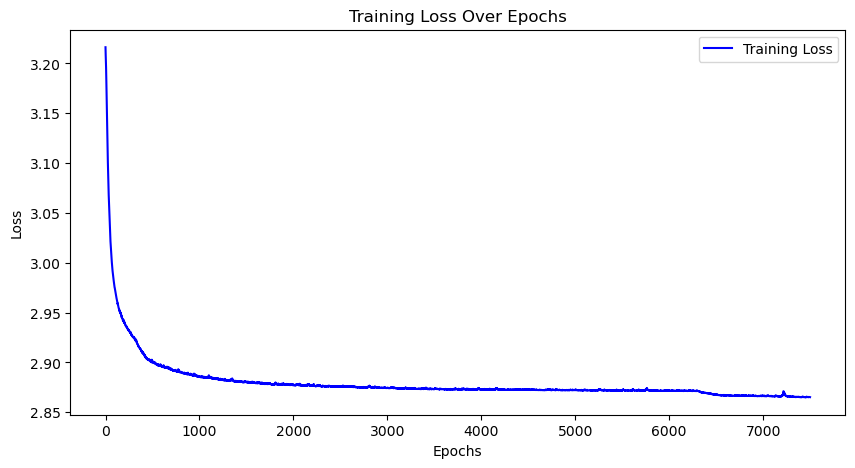

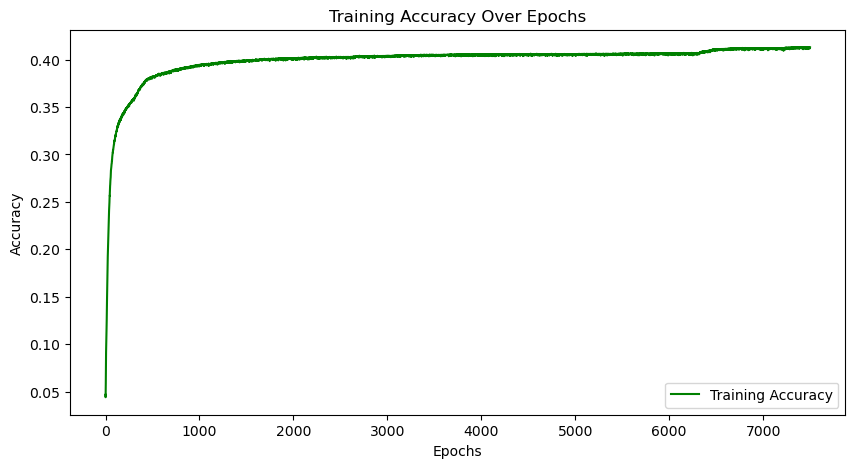

In [38]:
# 損失関数のグラフ
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), train_losses, label='Training Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss Over Epochs')
plt.show()

# 正解率のグラフ
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), train_accs, label='Training Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Accuracy Over Epochs')
plt.show()

実際に予測値と正解がどうなっているか見てみる

In [49]:
print(pred[:20])

tensor([ 7,  1, 11, 21, 22,  1, 10, 20,  5,  5,  0, 10,  0, 22, 24,  4, 16,  9,
         1, 18])


In [50]:
print(targets[:20])

tensor([ 6,  3, 11, 21, 24,  4, 10, 18,  5,  4,  1, 19, 10, 19, 16,  8, 21,  9,
         4, 17])


モデルの保存

In [40]:
params = model.state_dict()

In [41]:
torch.save(params, "model.prm")